In [16]:
## Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing import Tuple
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

In [17]:
df = pd.read_csv(r'C:\Users\MrKup\Downloads\archive\steam.csv')

print(df.head())
print(df.info())

   appid                       name release_date  english         developer  \
0     10             Counter-Strike   2000-11-01        1             Valve   
1     20      Team Fortress Classic   1999-04-01        1             Valve   
2     30              Day of Defeat   2003-05-01        1             Valve   
3     40         Deathmatch Classic   2001-06-01        1             Valve   
4     50  Half-Life: Opposing Force   1999-11-01        1  Gearbox Software   

  publisher          platforms  required_age  \
0     Valve  windows;mac;linux             0   
1     Valve  windows;mac;linux             0   
2     Valve  windows;mac;linux             0   
3     Valve  windows;mac;linux             0   
4     Valve  windows;mac;linux             0   

                                          categories  genres  \
0  Multi-player;Online Multi-Player;Local Multi-P...  Action   
1  Multi-player;Online Multi-Player;Local Multi-P...  Action   
2              Multi-player;Valve Anti-Cheat

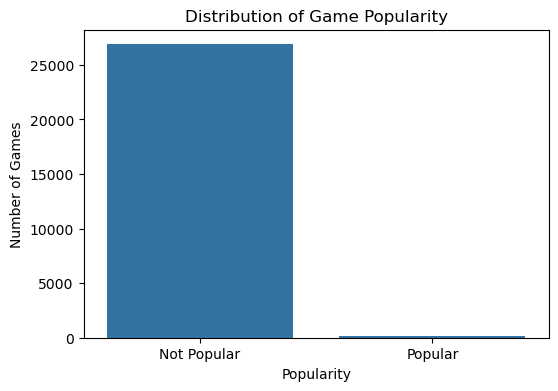

In [18]:
def classify_popularity(row):
    owner_min = int(row['owners'].split('-')[0].replace(',', ''))
    return 1 if row['positive_ratings'] > 10000 and owner_min > 1000000 else 0

df['popularity'] = df.apply(classify_popularity, axis = 1)

# Distribution of popularity
popularity_counts = df['popularity'].value_counts()
plt.figure(figsize = (6, 4))
sns.barplot(x = popularity_counts.index, y = popularity_counts.values)
plt.xticks(ticks = [0, 1], labels = ['Not Popular', 'Popular'])
plt.title('Distribution of Game Popularity')
plt.xlabel('Popularity')
plt.ylabel('Number of Games')
plt.show()

In [19]:
# Splitining data into the 3 sets
def get_train_valid_test_data(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, ...]:
    """
    Randomizes and splits the data into train, validation, and test sets.

    Args:
        X: Data given as a 2D matrix.
        y: Labels given as a vector.

    Returns:
        X_trn, y_trn, X_vld, y_vld, X_tst, y_tst: The split data.
    """
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=0.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=0.8, random_state=42)
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

# Function to preprocess the Steam dataset
def get_preprocessed_data() -> Tuple[np.ndarray, ...]:
    """
    Preprocesses the Steam dataset and returns training, validation, and testing data.

    Returns:
        A tuple of NumPy arrays:
        - indices 0-1 contain the training data/targets,
        - indices 2-3 contain the validation data/targets,
        - indices 4-5 contain the testing data/targets.
    """
    
    file_path = r'C:\Users\MrKup\Downloads\archive\steam.csv'
    df = pd.read_csv(file_path)

    df = df.drop(columns=['appid', 'name', 'release_date', 'developer', 
                          'publisher', 'platforms', 'categories', 'steamspy_tags', 'owners'])

    genres_encoded = df['genres'].str.get_dummies(sep=',')
    df = pd.concat([df, genres_encoded], axis=1)
    df.drop('genres', axis = 1, inplace = True)
    
    X = df.drop(columns = ['median_playtime', 'average_playtime']).values
    y = df['median_playtime'].values

    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(X, y)

    scaler = StandardScaler()
    X_trn = scaler.fit_transform(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)
    
    return (
        X_trn, y_trn.reshape(-1, 1), 
        X_vld, y_vld.reshape(-1, 1), 
        X_tst, y_tst.reshape(-1, 1)
    )

X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data()

# Confirm shapes of the processed data
print(f"Training Data Shape: {X_trn.shape}, Training Targets Shape: {y_trn.shape}")
print(f"Validation Data Shape: {X_vld.shape}, Validation Targets Shape: {y_vld.shape}")
print(f"Testing Data Shape: {X_tst.shape}, Testing Targets Shape: {y_tst.shape}")

Training Data Shape: (17328, 1558), Training Targets Shape: (17328, 1)
Validation Data Shape: (4332, 1558), Validation Targets Shape: (4332, 1)
Testing Data Shape: (5415, 1558), Testing Targets Shape: (5415, 1)


In [20]:
# Train Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_trn, y_trn)

# Predict & Evaluate 
y_pred_lr = model_lr.predict(X_vld)
print("Linear Regression - Validation MSE:", mean_squared_error(y_vld, y_pred_lr))

# Evaluate with R² Score
print("Linear Regression  - Validation R²:", r2_score(y_vld, y_pred_lr))

Linear Regression - Validation MSE: 5.520553477770126e+30
Linear Regression  - Validation R²: -1.1030345887123701e+25


In [21]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
model_rf = RandomForestRegressor(n_estimators = 50, random_state = 42)

model_rf.fit(X_trn, y_trn.ravel())  # Flatten the target array

# Predict & Evaluate
y_pred_rf = model_rf.predict(X_vld)
print("Random Forest - Validation MSE:", mean_squared_error(y_vld, y_pred_rf))

Random Forest - Validation MSE: 3126265.5811420055


In [22]:
# Linear Regression model on the test set
y_pred_test_lr = model_lr.predict(X_tst)
print("Linear Regression - Test MSE:", mean_squared_error(y_tst, y_pred_test_lr))
print("Linear Regression - Test R²:", r2_score(y_tst, y_pred_test_lr))

# Random Forest model on the test set
y_pred_test_rf = model_rf.predict(X_tst)
print("Random Forest - Test MSE:", mean_squared_error(y_tst, y_pred_test_rf))
print("Random Forest - Test R²:", r2_score(y_tst, y_pred_test_rf))

Linear Regression - Test MSE: 4.891842336752005e+30
Linear Regression - Test R²: -3.086518060447599e+23
Random Forest - Test MSE: 19535715.35409511
Random Forest - Test R²: -0.23261000893608386


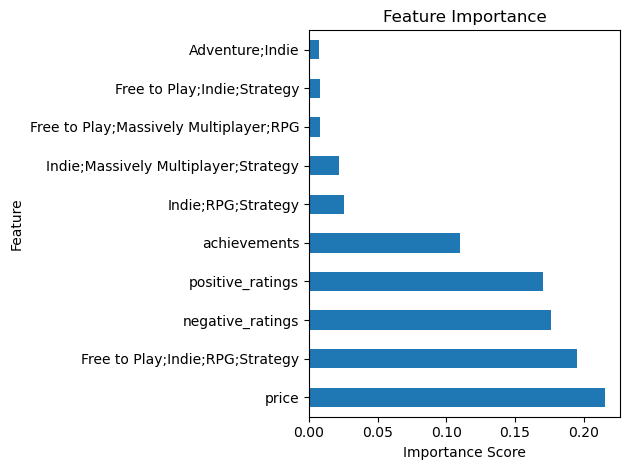

In [23]:
file_path = r'C:\Users\MrKup\Downloads\archive\steam.csv'
df = pd.read_csv(file_path)

# Not relevent coloumns 
df = df.drop(columns = ['appid', 'name', 'release_date', 'developer', 
                      'publisher', 'platforms', 'categories', 'steamspy_tags', 'owners'])

genres_encoded = df['genres'].str.get_dummies(sep = ',')
df = pd.concat([df, genres_encoded], axis = 1)
df.drop('genres', axis = 1, inplace = True)

# Save feature names after preprocessing
feature_columns = df.drop(columns = ['median_playtime', 'average_playtime']).columns

# Alignment between model and feature names
if len(model_rf.feature_importances_) == len(feature_columns):
    feature_importances = pd.Series(model_rf.feature_importances_, index = feature_columns)

    feature_importances.nlargest(10).plot(kind = 'barh', title = "Feature Importance")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("The feature lengths don't match. Verify steps!!.")
    print(f"Feature importance length (model): {len(model_rf.feature_importances_)}")
    print(f"Feature columns length (data): {len(feature_columns)}")

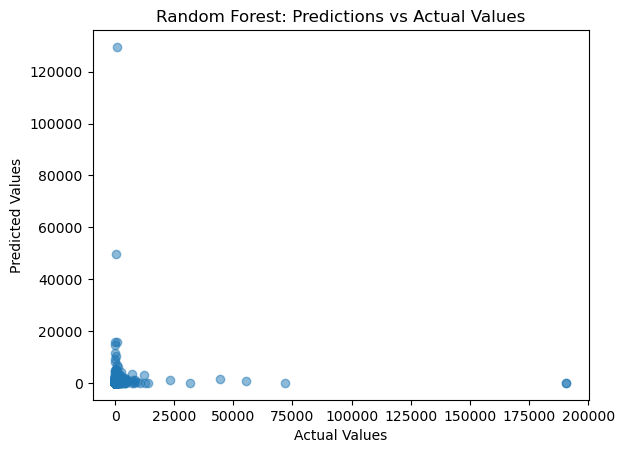

In [24]:
import matplotlib.pyplot as plt

# Random Forest predictions vs. actual values
plt.scatter(y_tst, y_pred_test_rf, alpha=0.5)
plt.title("Random Forest: Predictions vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

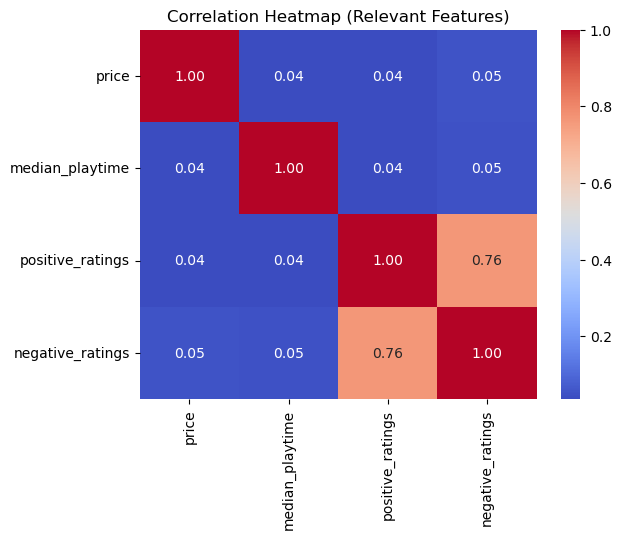

In [25]:
relevant_features = ['price', 'median_playtime', 'positive_ratings', 'negative_ratings']
corr_matrix = df[relevant_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Relevant Features)")
plt.show()

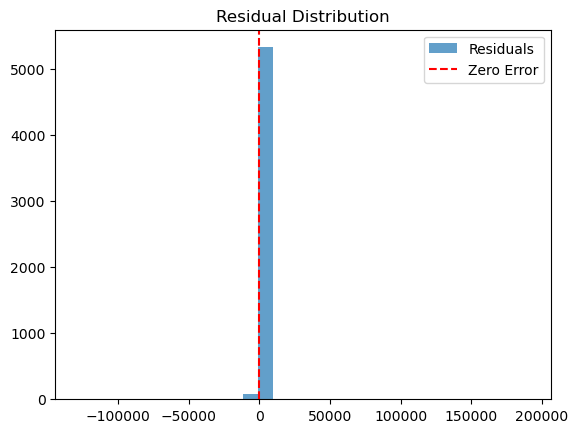

In [26]:
residuals = y_tst.ravel() - y_pred_test_rf
plt.hist(residuals, bins=30, alpha=0.7, label="Residuals")
plt.axvline(x=0, color='red', linestyle='--', label="Zero Error")
plt.title("Residual Distribution")
plt.legend()
plt.show()